## An efficient implementation of the Travelling Salesman Problem using QUBO Optimization :  Optimizing QCBO (Constrained QUBO) using Quantum Annealing Part II

### Getting Started

In the previous notebook, we demonstrated the formulation of the Travelling Salesman Problem (TSP) using linear integer programming, and implemented it using D-Wave's CQM. We noted that the number of constraints required for the implementation of the problem was exponential in size. 

In this notebook, we will propose a more efficient solution to implement the Subtour Elimination Constraint. This will assist us with solving larger problems, and thus providing application for practical problems, such as Vehicle Routing Problem (VRP) on a small city-level.

### Subtour Elimination Constraint

We talked about the Subtour Elimination Constraint in the previous notebook, where we compared DFJ with MTZ approach. Though the DFJ approach is more efficient, it is still very expensive as it grows exponentially. In this notebook, we will propose Gavish and Graves approach, which requires $N(N + 1)$ constraints, $N(N − 1)$ binary variables, and $N(N − 1)$ continues variables, which scales polynomially with the number of nodes. This approach has been ranked through SECA, and is the better choice between DFJ and MTZ [1].

Let us start by bringing the class from the previous notebook here.

In [1]:
# Author: Amirali Malekani Nezhad, 2023

from __future__ import annotations
import itertools
from typing import Any

__all__ = ['QTSP']

from abc import ABC, abstractmethod
from collections.abc import Container, Iterable
import os
os.chdir('..')

from dimod.serialization.format import Formatter
from dimod import ConstrainedQuadraticModel, Binary, quicksum
from dwave.system import LeapHybridCQMSampler
import numpy as np
import itertools
from matplotlib import pyplot as plt


class QTSP(ABC):
    """ `QTSP` is a class for implementing a CQM for the Travelling Salesman Problem.

    Parameters
    ----------
    coordinates : Iterable[Iterable[float]]
        The coordinates of the nodes of the graph.
    time : int
        The time limit for the problem.
    log : bool
        Whether to log the output or not.
    """
    def __init__(self,
                 coordinates: Iterable[Iterable[float]],
                 time: int,
                 log: bool = True):
        self.coordinates = coordinates
        self.num_nodes = len(self.coordinates)
        self.time_limit = time
        self.log = log
        # Construct the CQM
        self.cqm = self.define_CQM()

    def define_distance_matrix(self):
        """ Function to define the distance matrix for the given coordinates. This
        provides support for asymmetrical TSP.
        """
        # Distance Matrix
        Distance_matrix = []
        temp_set = []

        # Function for calculating the euclidean distance
        def distance_between_points(point_A, point_B):
            return np.sqrt((point_A[0] - point_B[0]) ** 2 + (point_A[1] - point_B[1]) ** 2)

        # Generating the distance matrix
        for i in range(len(self.coordinates)):
            for j in range(len(self.coordinates)):
                temp_set.append(distance_between_points(self.coordinates[i], self.coordinates[j]))
            Distance_matrix.append(temp_set)
            temp_set = []

        return Distance_matrix

    def generate_subtours(self):
        """ Function to generate the subtours for the given graph.
        """
        # Initialize subtours list
        subtours = []
        temp_list = []

        # Function to generate the subsets of a list given size
        def find_subsets(s, n):
            return list(itertools.combinations(s, n))

        for i in range(2, self.num_nodes):
            temp_list = find_subsets(range(self.num_nodes), i)
            for j in range(len(temp_list)):
                subtours.append(temp_list[j])
        return subtours

    def define_CQM(self):
        """ Function to define the CQM for the given graph.
        """
        # Construct the distance matrix
        Distance_matrix = self.define_distance_matrix()

        # Generate subtours
        subtours = self.generate_subtours()

        # Define the number of subtours
        S = len(subtours)

        # Initialize the CQM
        cqm = ConstrainedQuadraticModel()

        # Initialize the objective
        objective = 0

        # Initialize the constraints
        constraint_1 = 0
        constraint_2 = 0
        constraint_3 = 0

        # Initialize the decision var
        X_ = []

        # Define objective
        for i in range(self.num_nodes):
            for j in range(self.num_nodes):
                if i == j:
                    X_.append(0)
                else:
                    X_.append(Binary('X_' + str(i + 1) + "_" + str(j + 1)))
            objective += quicksum(Distance_matrix[j][i] * X_[j] for j in range(self.num_nodes))
            cqm.set_objective(objective)
            X_.clear()

        # Define Constraints (Only one entry and exit per node)
        for i in range(self.num_nodes):
            for j in range(self.num_nodes):
                if i == j:
                    X_.append(0)
                else:
                    X_.append(Binary('X_' + str(i + 1) + "_" + str(j + 1)))
            constraint_1 = quicksum(X_[j] for j in range(self.num_nodes))
            cqm.add_constraint(constraint_1 == 1, label="Constraint 1-" + str(i + 1))
            X_.clear()

        for j in range(self.num_nodes):
            for i in range(self.num_nodes):
                if i == j:
                    X_.append(0)
                else:
                    X_.append(Binary('X_' + str(i + 1) + "_" + str(j + 1)))
            constraint_2 = quicksum(X_[i] for i in range(self.num_nodes))
            cqm.add_constraint(constraint_2 == 1, label="Constraint 2-" + str(j + 1))
            X_.clear()

        # Define subtour elimination constraint
        for s in range(S):  # s = {1,2}, length of s = 1, so 1 iterations of below
            for i in (subtours[s]):  # len of subtour = 2, so 2 iterations
                for j in (subtours[s]):  # len of subtour = 2 so 2 iterations
                    # possible X_ : X1,1 X1,2 X2,1 X2,2
                    if i == j:
                        continue  # X1,1 and X2,2 are not accepted
                    else:
                        X_.append(Binary('X_' + str(i + 1) + "_" + str(j + 1)))
            constraint_3 = quicksum(X_[j] for j in range(len(X_)))
            cqm.add_constraint(constraint_3 <= len(subtours[s]) - 1, label="Constraint 3-" + str(s + 1))
            X_.clear()

        return cqm

    def __call__(self):
        # Running the sampler to get the sample set
        cqm_sampler = LeapHybridCQMSampler()
        sampleset = cqm_sampler.sample_cqm(self.cqm, label='CQM-TSP', time_limit=self.time_limit)

        if self.log:
            # Printing the sample set
            for c, cval in self.cqm.constraints.items():
                print(c, cval)

        feasible_sampleset = sampleset.filter(lambda d: d.is_feasible)

        sample = feasible_sampleset.first.sample

        if self.log:
            Formatter(width=1000).fprint(feasible_sampleset)

            for constraint in self.cqm.iter_constraint_data(sample):
                print(constraint.label, constraint.violation)

            for c, v in self.cqm.constraints.items():
                print('lhs : ' + str(v.lhs.energy(sample)))
                print('rhs : ' + str(v.rhs))
                print('sense  : ' + str(v.sense))
                print("---")

        sample_keys = sample.keys()
        sample_solutions = []
        for key in sample_keys:
            if sample.get(key) == 1:
                sample_solutions.append(key)
        
        if self.log:
            print(sample_solutions)

        def containsNumber(value):
            num_list = []
            for character in value:
                if character.isdigit():
                    num_list.append(int(character) - 1)
            return num_list
    
        sample_coordinate_sequence = []
        for i in range(len(sample_solutions)):
            res = containsNumber(sample_solutions[i])
            sample_coordinate_sequence.append(res)

        plt.scatter(self.coordinates[:, 0], self.coordinates[:, 1])

        for i in sample_coordinate_sequence:
            start = self.coordinates[i[0]]
            end = self.coordinates[i[1]]
            plt.plot([start[0], end[0]], [start[1], end[1]])

        plt.show()

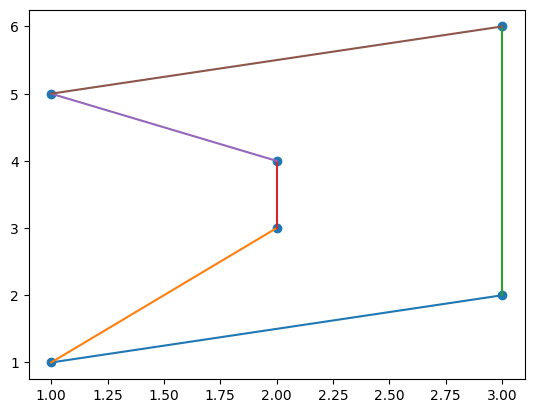

In [2]:
# List of coordinates
coordinates = np.array([[1, 1], [2, 3], [3, 2], [2, 4], [1, 5], [3, 6]])   # 6 nodes

tsp_model = QTSP(coordinates=coordinates, time=30, log=False)

tsp_model()

We saw that we can create a solver for QTSP and call it for arbitrary diagrams, well not quite. As mentioned before, theoretically we can apply this to any diagram, but practically that becomes exponentially more expensive, so the size of problems we can effectively solve is very small. This would mean that the implementation, though providing Quantum advantage, is only applicable to trivial problems, which in the industry would deem it as useless. This is why we are going to take this implementation one step further, and make it more practical.

We start by explaining the Gavish-Graves (GG) subtour elmination constraint [2]. A large class of extended ATSP formulations is known as commodity flow formulations, where the additional variables represent commodity flows through the arcs and satisfy additional flow conservation constraints. These models belong to three classes: single-commodity flow (SCF), two-commodity flow (TCF), and multi-commodity flow (MCF) formulations. The earliest SCF formulation is due to Gavish and Graves. The additional continuous non-negative variables zij describe a single commodity’s flow vertex 1 from every other vertex. The GG formulation for a single commodity problem that has sub-tour elimination constraints in it is

$∑_{j=1} z_{ij} - ∑_{j≠1} z_{ij} = 1$               $i = 2,…,n$   (1)

$z_{ij} ≤ (n - 1) y_{ij}$,        $i = 2,…,n$   and   $j = 1,…,n$   (2)

$z_{ij} ≥ 0$    for all   $i, j$   (3)

In this formulation, z is a positive variable. yij is a binary variable and is equal to 1 when the nodes of i,j are visited. Constraint (7) ensures that the flow variable ($Z_{ij}$) exists between nodes with one unit following. Constraint (8) assures that a flow is possible when the nodes are connected ($y_{ij} = 1$).

Let us start with a brute forced implementation first.HOWEVER, we're gonna do it a bit more elegantly this time, HEHEHEHE.

In [3]:
# Function to check if a string has a number in it
def containsNumber(value):
    num_list = []
    for character in value:
        if character.isdigit():
            num_list.append(int(character) - 1)
    return num_list

# Function to generate the subsets of a list given size
def findsubsets(s, n):
    return list(itertools.combinations(s, n))


# Function to generate all the subsets of a list
def find_all_subsets(s):
    subtours = []
    temp_list = []
    for i in range(2, len(s)):
        temp_list = findsubsets(s, i)
        for j in range(len(temp_list)):
            subtours.append(temp_list[j])
    return subtours


# Function for calculating the euclidean distance
def distance_between_points(point_A, point_B):
    return np.sqrt((point_A[0] - point_B[0]) ** 2 + (point_A[1] - point_B[1]) ** 2)

In [4]:
# List of coordinates
coordinates = np.array([[1, 1], [2, 3], [3, 2], [2, 4], [1, 5], [3, 6]])   # 6 nodes

x_vals = coordinates[:, 0]
y_vals = coordinates[:, 1]

# Number of nodes
n = len(coordinates)
global_set = [i for i in range(n)]

# List of subtours
subtours = find_all_subsets(global_set)

# Number of subsets
S = len(subtours)

# Distance Matrix
Distance_matrix = []
temp_set = []

# Generating the distance matrix
for i in range(n):
    for j in range(n):
        temp_set.append(distance_between_points(coordinates[i], coordinates[j]))
    Distance_matrix.append(temp_set)
    temp_set = []

In [5]:
# Initializing the CQM
cqm = ConstrainedQuadraticModel()

In the previous notebook, we kept creating and clearing the decision variables for the objective and constraint loops. Whilst this approach works well, it is not an elegant way of coding such problems. Instead, we are going to create the decision variables once, and in the objective and constraints simply call the appropriate decision variables. As a reminder, we mentioned the decision variables are of form $X_{ij}$ where i and j are the indices of the nodes, and if $X_{ij}$ is set to one, then there is a edge going from i to j. It is worth noting that $X_{ij}$ is not the same as $X_{ji}$, as TSP is generally asymmetric.

In [6]:
# Initializing the decision var
X = np.array([[Binary(f"X_{i+1}_{j+1}") if i!=j else 0 for j in range(n)] for i in range(n)])

print(X)

[[0 BinaryQuadraticModel({'X_1_2': 1.0}, {}, 0.0, 'BINARY')
  BinaryQuadraticModel({'X_1_3': 1.0}, {}, 0.0, 'BINARY')
  BinaryQuadraticModel({'X_1_4': 1.0}, {}, 0.0, 'BINARY')
  BinaryQuadraticModel({'X_1_5': 1.0}, {}, 0.0, 'BINARY')
  BinaryQuadraticModel({'X_1_6': 1.0}, {}, 0.0, 'BINARY')]
 [BinaryQuadraticModel({'X_2_1': 1.0}, {}, 0.0, 'BINARY') 0
  BinaryQuadraticModel({'X_2_3': 1.0}, {}, 0.0, 'BINARY')
  BinaryQuadraticModel({'X_2_4': 1.0}, {}, 0.0, 'BINARY')
  BinaryQuadraticModel({'X_2_5': 1.0}, {}, 0.0, 'BINARY')
  BinaryQuadraticModel({'X_2_6': 1.0}, {}, 0.0, 'BINARY')]
 [BinaryQuadraticModel({'X_3_1': 1.0}, {}, 0.0, 'BINARY')
  BinaryQuadraticModel({'X_3_2': 1.0}, {}, 0.0, 'BINARY') 0
  BinaryQuadraticModel({'X_3_4': 1.0}, {}, 0.0, 'BINARY')
  BinaryQuadraticModel({'X_3_5': 1.0}, {}, 0.0, 'BINARY')
  BinaryQuadraticModel({'X_3_6': 1.0}, {}, 0.0, 'BINARY')]
 [BinaryQuadraticModel({'X_4_1': 1.0}, {}, 0.0, 'BINARY')
  BinaryQuadraticModel({'X_4_2': 1.0}, {}, 0.0, 'BINARY')
  Bin

In [7]:
# Defining objective
objective = quicksum(Distance_matrix[i][j] * X[i][j] for i in range(n) for j in range(n))
cqm.set_objective(objective)

In [8]:
for i in range(n):
    constraint_1 = quicksum(X[i][j] for j in range(n))
    print("Constraint 1-" + str(i+1))
    cqm.add_constraint(constraint_1 == 1, label="Constraint 1-" + str(i+1))
    

Constraint 1-1
Constraint 1-2
Constraint 1-3
Constraint 1-4
Constraint 1-5
Constraint 1-6


In [9]:
for j in range(n):
    constraint_2 = quicksum(X[i][j] for i in range(n))
    print("Constraint 2-" + str(j+1))
    cqm.add_constraint(constraint_2 == 1, label="Constraint 2-" + str(j+1))

Constraint 2-1
Constraint 2-2
Constraint 2-3
Constraint 2-4
Constraint 2-5
Constraint 2-6


In [10]:
for s in range(S):
    print(subtours[s])
    constraint_3 = quicksum(X[i][j] for i in (subtours[s]) for j in (subtours[s]) if i!=j)
    print("Constraint 3-" + str(s + 1))
    cqm.add_constraint(constraint_3 <= len(subtours[s]) - 1, label="Constraint 3-" + str(s + 1))

(0, 1)
Constraint 3-1
(0, 2)
Constraint 3-2
(0, 3)
Constraint 3-3
(0, 4)
Constraint 3-4
(0, 5)
Constraint 3-5
(1, 2)
Constraint 3-6
(1, 3)
Constraint 3-7
(1, 4)
Constraint 3-8
(1, 5)
Constraint 3-9
(2, 3)
Constraint 3-10
(2, 4)
Constraint 3-11
(2, 5)
Constraint 3-12
(3, 4)
Constraint 3-13
(3, 5)
Constraint 3-14
(4, 5)
Constraint 3-15
(0, 1, 2)
Constraint 3-16
(0, 1, 3)
Constraint 3-17
(0, 1, 4)
Constraint 3-18
(0, 1, 5)
Constraint 3-19
(0, 2, 3)
Constraint 3-20
(0, 2, 4)
Constraint 3-21
(0, 2, 5)
Constraint 3-22
(0, 3, 4)
Constraint 3-23
(0, 3, 5)
Constraint 3-24
(0, 4, 5)
Constraint 3-25
(1, 2, 3)
Constraint 3-26
(1, 2, 4)
Constraint 3-27
(1, 2, 5)
Constraint 3-28
(1, 3, 4)
Constraint 3-29
(1, 3, 5)
Constraint 3-30
(1, 4, 5)
Constraint 3-31
(2, 3, 4)
Constraint 3-32
(2, 3, 5)
Constraint 3-33
(2, 4, 5)
Constraint 3-34
(3, 4, 5)
Constraint 3-35
(0, 1, 2, 3)
Constraint 3-36
(0, 1, 2, 4)
Constraint 3-37
(0, 1, 2, 5)
Constraint 3-38
(0, 1, 3, 4)
Constraint 3-39
(0, 1, 3, 5)
Constraint 3-40

In [11]:
# Running the sampler to get the sample set
cqm_sampler = LeapHybridCQMSampler()
sampleset = cqm_sampler.sample_cqm(cqm, label='CQM-TSP', time_limit=30)

In [12]:
# Printing the sample set
for c, cval in cqm.constraints.items():
    print(c, cval)
    
feasible_sampleset = sampleset.filter(lambda d: d.is_feasible)

sample = feasible_sampleset.first.sample
Formatter(width=1000).fprint(feasible_sampleset)

0   0.0   0.0   1.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0 13.122417       1 arra...    True
22    1.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   1.0   0.0   0.0 13.122417       1 arra...    True
23    0.0   1.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0 13.122417       1 arra...    True
24    0.0   1.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   1.0 13.122417       1 arra...    True
25    0.0   0.0   0.0   1.0   0.0   0.0   1.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   1.0   0.0 13.122417       1 arra...    True
26    0.0   1.

In [13]:
for constraint in cqm.iter_constraint_data(sample):
    print(constraint.label, constraint.violation)

Constraint 1-1 0.0
Constraint 1-2 0.0
Constraint 1-3 0.0
Constraint 1-4 0.0
Constraint 1-5 0.0
Constraint 1-6 0.0
Constraint 2-1 0.0
Constraint 2-2 0.0
Constraint 2-3 0.0
Constraint 2-4 0.0
Constraint 2-5 0.0
Constraint 2-6 0.0
Constraint 3-1 -1.0
Constraint 3-2 0.0
Constraint 3-3 -1.0
Constraint 3-4 0.0
Constraint 3-5 -1.0
Constraint 3-6 0.0
Constraint 3-7 0.0
Constraint 3-8 -1.0
Constraint 3-9 -1.0
Constraint 3-10 -1.0
Constraint 3-11 -1.0
Constraint 3-12 -1.0
Constraint 3-13 -1.0
Constraint 3-14 0.0
Constraint 3-15 0.0
Constraint 3-16 0.0
Constraint 3-17 -1.0
Constraint 3-18 -1.0
Constraint 3-19 -2.0
Constraint 3-20 -1.0
Constraint 3-21 0.0
Constraint 3-22 -1.0
Constraint 3-23 -1.0
Constraint 3-24 -1.0
Constraint 3-25 0.0
Constraint 3-26 0.0
Constraint 3-27 -1.0
Constraint 3-28 -1.0
Constraint 3-29 -1.0
Constraint 3-30 0.0
Constraint 3-31 -1.0
Constraint 3-32 -2.0
Constraint 3-33 -1.0
Constraint 3-34 -1.0
Constraint 3-35 0.0
Constraint 3-36 0.0
Constraint 3-37 0.0
Constraint 3-38 -1

In [14]:
for c, v in cqm.constraints.items():
    print('lhs : ' + str(v.lhs.energy(sample)))
    print('rhs : ' + str(v.rhs))
    print('sense  : ' + str(v.sense))
    print("---")

lhs : 1.0
rhs : 1.0
sense  : Sense.Eq
---
lhs : 1.0
rhs : 1.0
sense  : Sense.Eq
---
lhs : 1.0
rhs : 1.0
sense  : Sense.Eq
---
lhs : 1.0
rhs : 1.0
sense  : Sense.Eq
---
lhs : 1.0
rhs : 1.0
sense  : Sense.Eq
---
lhs : 1.0
rhs : 1.0
sense  : Sense.Eq
---
lhs : 1.0
rhs : 1.0
sense  : Sense.Eq
---
lhs : 1.0
rhs : 1.0
sense  : Sense.Eq
---
lhs : 1.0
rhs : 1.0
sense  : Sense.Eq
---
lhs : 1.0
rhs : 1.0
sense  : Sense.Eq
---
lhs : 1.0
rhs : 1.0
sense  : Sense.Eq
---
lhs : 1.0
rhs : 1.0
sense  : Sense.Eq
---
lhs : 0.0
rhs : 1.0
sense  : Sense.Le
---
lhs : 1.0
rhs : 1.0
sense  : Sense.Le
---
lhs : 0.0
rhs : 1.0
sense  : Sense.Le
---
lhs : 1.0
rhs : 1.0
sense  : Sense.Le
---
lhs : 0.0
rhs : 1.0
sense  : Sense.Le
---
lhs : 1.0
rhs : 1.0
sense  : Sense.Le
---
lhs : 1.0
rhs : 1.0
sense  : Sense.Le
---
lhs : 0.0
rhs : 1.0
sense  : Sense.Le
---
lhs : 0.0
rhs : 1.0
sense  : Sense.Le
---
lhs : 0.0
rhs : 1.0
sense  : Sense.Le
---
lhs : 0.0
rhs : 1.0
sense  : Sense.Le
---
lhs : 0.0
rhs : 1.0
sense  : Sense

In [15]:
sample_keys = sample.keys()
sample_solutions = []
for key in sample_keys:
    if sample.get(key) == 1:
        sample_solutions.append(key)
print(sample_solutions)

['X_1_5', 'X_2_3', 'X_3_1', 'X_4_2', 'X_5_6', 'X_6_4']


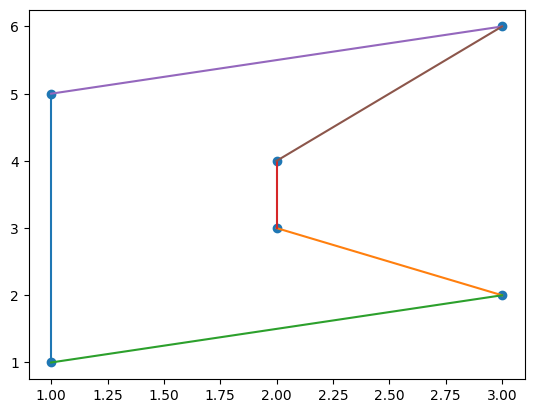

In [16]:
sample_coordinate_sequence = []
for i in range(len(sample_solutions)):
    res = containsNumber(sample_solutions[i])
    sample_coordinate_sequence.append(res)

plt.scatter(x_vals, y_vals)

for i in sample_coordinate_sequence:
    start = coordinates[i[0]]
    end = coordinates[i[1]]
    plt.plot([start[0], end[0]], [start[1], end[1]])

plt.show()

Great, now we have a more elegant code. Same as before, we are going to package this into a class.

In [17]:
# Author: Amirali Malekani Nezhad, 2023

from __future__ import annotations
import itertools
from typing import Any

__all__ = ['QTSP']

from abc import ABC, abstractmethod
from collections.abc import Container, Iterable
import os
os.chdir('..')

from dimod.serialization.format import Formatter
from dimod import ConstrainedQuadraticModel, Binary, quicksum
from dwave.system import LeapHybridCQMSampler
import numpy as np
import itertools
from matplotlib import pyplot as plt


class QTSP(ABC):
    """ `QTSP` is a class for implementing a CQM for the Travelling Salesman Problem.

    Parameters
    ----------
    coordinates : Iterable[Iterable[float]]
        The coordinates of the nodes of the graph.
    time : int
        The time limit for the problem.
    log : bool
        Whether to log the output or not.
    """
    def __init__(self,
                 coordinates: Iterable[Iterable[float]],
                 time: int,
                 log: bool = True):
        self.coordinates = coordinates
        self.num_nodes = len(self.coordinates)
        self.time_limit = time
        self.log = log
        # Construct the CQM
        self.cqm = self.define_CQM()

    def define_distance_matrix(self):
        """ Function to define the distance matrix for the given coordinates. This
        provides support for asymmetrical TSP.
        """
        # Distance Matrix
        Distance_matrix = []
        temp_set = []

        # Function for calculating the euclidean distance
        def distance_between_points(point_A, point_B):
            return np.sqrt((point_A[0] - point_B[0]) ** 2 + (point_A[1] - point_B[1]) ** 2)

        # Generating the distance matrix
        for i in range(len(self.coordinates)):
            for j in range(len(self.coordinates)):
                temp_set.append(distance_between_points(self.coordinates[i], self.coordinates[j]))
            Distance_matrix.append(temp_set)
            temp_set = []

        return Distance_matrix

    def generate_subtours(self):
        """ Function to generate the subtours for the given graph.
        """
        # Initialize subtours list
        subtours = []
        temp_list = []

        # Function to generate the subsets of a list given size
        def find_subsets(s, n):
            return list(itertools.combinations(s, n))

        for i in range(2, self.num_nodes):
            temp_list = find_subsets(range(self.num_nodes), i)
            for j in range(len(temp_list)):
                subtours.append(temp_list[j])
        return subtours

    def define_CQM(self):
        """ Function to define the CQM for the given graph.
        """
        # Define the number of nodes
        n = self.num_nodes

        # Construct the distance matrix
        Distance_matrix = self.define_distance_matrix()

        # Generate subtours
        subtours = self.generate_subtours()

        # Define the number of subtours
        S = len(subtours)
    
        # Initialize the CQM
        cqm = ConstrainedQuadraticModel()

        # Initialize the objective
        objective = 0

        # Initialize the constraints
        constraint_1 = 0
        constraint_2 = 0
        constraint_3 = 0

        # Initialize the decision var
        X = np.array([[Binary(f"X_{i+1}_{j+1}") if i!=j else 0 for j in range(n)] for i in range(n)])

        # Define objective
        objective = quicksum(Distance_matrix[i][j] * X[i][j] for i in range(n) for j in range(n))
        cqm.set_objective(objective)

        # Define Constraints (Only one entry and exit per node)
        for i in range(n):
            constraint_1 = quicksum(X[i][j] for j in range(n))
            cqm.add_constraint(constraint_1 == 1, label="Constraint 1-" + str(i+1))

        for j in range(n):
            constraint_2 = quicksum(X[i][j] for i in range(n))
            cqm.add_constraint(constraint_2 == 1, label="Constraint 2-" + str(j+1))

        # Define subtour elimination constraint
        for s in range(S):
            constraint_3 = quicksum(X[i][j] for i in (subtours[s]) for j in (subtours[s]) if i!=j)
            cqm.add_constraint(constraint_3 <= len(subtours[s]) - 1, label="Constraint 3-" + str(s + 1))

        return cqm

    def __call__(self):
        # Running the sampler to get the sample set
        cqm_sampler = LeapHybridCQMSampler()
        sampleset = cqm_sampler.sample_cqm(self.cqm, label='CQM-TSP', time_limit=self.time_limit)

        if self.log:
            # Printing the sample set
            for c, cval in self.cqm.constraints.items():
                print(c, cval)

        feasible_sampleset = sampleset.filter(lambda d: d.is_feasible)

        sample = feasible_sampleset.first.sample

        if self.log:
            Formatter(width=1000).fprint(feasible_sampleset)

            for constraint in self.cqm.iter_constraint_data(sample):
                print(constraint.label, constraint.violation)

            for c, v in self.cqm.constraints.items():
                print('lhs : ' + str(v.lhs.energy(sample)))
                print('rhs : ' + str(v.rhs))
                print('sense  : ' + str(v.sense))
                print("---")

        sample_keys = sample.keys()
        sample_solutions = []
        for key in sample_keys:
            if sample.get(key) == 1:
                sample_solutions.append(key)
        
        if self.log:
            print(sample_solutions)

        def containsNumber(value):
            num_list = []
            for character in value:
                if character.isdigit():
                    num_list.append(int(character) - 1)
            return num_list
    
        sample_coordinate_sequence = []
        for i in range(len(sample_solutions)):
            res = containsNumber(sample_solutions[i])
            sample_coordinate_sequence.append(res)

        plt.scatter(self.coordinates[:, 0], self.coordinates[:, 1])

        for i in sample_coordinate_sequence:
            start = self.coordinates[i[0]]
            end = self.coordinates[i[1]]
            plt.plot([start[0], end[0]], [start[1], end[1]])

        plt.show()

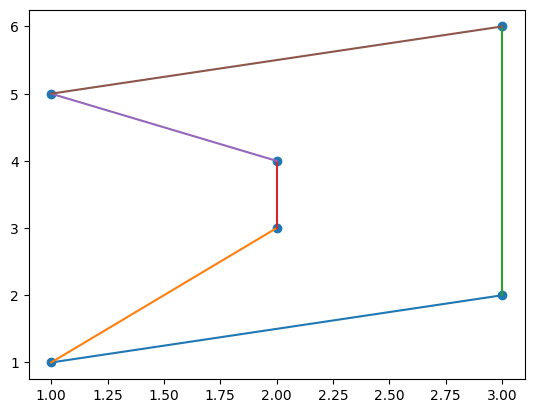

In [18]:
# List of coordinates
coordinates = np.array([[1, 1], [2, 3], [3, 2], [2, 4], [1, 5], [3, 6]])   # 6 nodes

tsp_model = QTSP(coordinates=coordinates, time=30, log=False)

tsp_model()

Now we have a improved version of the QTSP with DFJ subtour elimination constraint. Next we need to implement the GG method. Once again, we start with a cell by cell approach, and once we have a functional code, we will package into a class.

In [19]:
# Function to check if a string has a number in it
def containsNumber(value):
    num_list = []
    for character in value:
        if character.isdigit():
            num_list.append(int(character) - 1)
    return num_list

# Function to generate the subsets of a list given size
def findsubsets(s, n):
    return list(itertools.combinations(s, n))


# Function to generate all the subsets of a list
def find_all_subsets(s):
    subtours = []
    temp_list = []
    for i in range(2, len(s)):
        temp_list = findsubsets(s, i)
        for j in range(len(temp_list)):
            subtours.append(temp_list[j])
    return subtours


# Function for calculating the euclidean distance
def distance_between_points(point_A, point_B):
    return np.sqrt((point_A[0] - point_B[0]) ** 2 + (point_A[1] - point_B[1]) ** 2)

In [20]:
# List of coordinates
coordinates = np.array([[1, 1], [2, 3], [3, 2], [2, 4], [1, 5], [3, 6]])   # 6 nodes

x_vals = coordinates[:, 0]
y_vals = coordinates[:, 1]

# Number of nodes
n = len(coordinates)
global_set = [i for i in range(n)]

# List of subtours
subtours = find_all_subsets(global_set)

# Number of subsets
S = len(subtours)

# Distance Matrix
Distance_matrix = []
temp_set = []

# Generating the distance matrix
for i in range(n):
    for j in range(n):
        temp_set.append(distance_between_points(coordinates[i], coordinates[j]))
    Distance_matrix.append(temp_set)
    temp_set = []

In [31]:
# Initializing the CQM
cqm = ConstrainedQuadraticModel()

In [32]:
# Initializing the decision var
X = np.array([[Binary(f"X_{i+1}_{j+1}") if i!=j else 0 for j in range(n)] for i in range(n)])

In [33]:
# Defining objective (note we are iterating over n-1, as we don't have X_ij where i=j)
objective = quicksum(Distance_matrix[i][j] * X[i][j] for i in range(n) for j in range(n))
cqm.set_objective(objective)

In [34]:
for i in range(n):
    constraint_1 = quicksum(X[i][j] for j in range(n))
    cqm.add_constraint(constraint_1 == 1, label="Constraint 1-" + str(i+1))

In [35]:
for j in range(n):
    constraint_2 = quicksum(X[i][j] for i in range(n))
    cqm.add_constraint(constraint_2 == 1, label="Constraint 2-" + str(j+1))

Here is where we implement the GG method. The GG method requires three constraints, namely (1), (2) and (3). We start by creating the continuous variables.


In [36]:
from dimod import Real

# Initializing the decision var
Z = np.array([[Real(f"Z_{i+1}_{j+1}") if i!=j else 0 for j in range(n)] for i in range(n)])

print(Z)

[[0
  QuadraticModel({'Z_1_2': 1.0}, {}, 0.0, {'Z_1_2': 'REAL'}, dtype='float64')
  QuadraticModel({'Z_1_3': 1.0}, {}, 0.0, {'Z_1_3': 'REAL'}, dtype='float64')
  QuadraticModel({'Z_1_4': 1.0}, {}, 0.0, {'Z_1_4': 'REAL'}, dtype='float64')
  QuadraticModel({'Z_1_5': 1.0}, {}, 0.0, {'Z_1_5': 'REAL'}, dtype='float64')
  QuadraticModel({'Z_1_6': 1.0}, {}, 0.0, {'Z_1_6': 'REAL'}, dtype='float64')]
 [QuadraticModel({'Z_2_1': 1.0}, {}, 0.0, {'Z_2_1': 'REAL'}, dtype='float64')
  0
  QuadraticModel({'Z_2_3': 1.0}, {}, 0.0, {'Z_2_3': 'REAL'}, dtype='float64')
  QuadraticModel({'Z_2_4': 1.0}, {}, 0.0, {'Z_2_4': 'REAL'}, dtype='float64')
  QuadraticModel({'Z_2_5': 1.0}, {}, 0.0, {'Z_2_5': 'REAL'}, dtype='float64')
  QuadraticModel({'Z_2_6': 1.0}, {}, 0.0, {'Z_2_6': 'REAL'}, dtype='float64')]
 [QuadraticModel({'Z_3_1': 1.0}, {}, 0.0, {'Z_3_1': 'REAL'}, dtype='float64')
  QuadraticModel({'Z_3_2': 1.0}, {}, 0.0, {'Z_3_2': 'REAL'}, dtype='float64')
  0
  QuadraticModel({'Z_3_4': 1.0}, {}, 0.0, {'Z_3_4'

In [37]:
for i in range(n):
    if i >= 1:
        constraint_3 = quicksum(Z[i][j] for j in range(n)) - quicksum(Z[j][i] for j in range(n) if j != 0)
        cqm.add_constraint(constraint_3 == 1, label="Constraint 3-" + str(i+1))

In [38]:
for i in range(n):
    for j in range(n):
        if i != 0:
            if X[i][j] == 0:
                pass
            else:
                constraint_4 = Z[i][j] - (n-1) * X[i][j]
                cqm.add_constraint(constraint_4, sense="<=", rhs=0, label=f"Constraint 4-{i+1}{j+1}")

In [39]:
# Running the sampler to get the sample set
cqm_sampler = LeapHybridCQMSampler()
sampleset = cqm_sampler.sample_cqm(cqm, label='CQM-TSP', time_limit=30)

In [40]:
# Printing the sample set
for c, cval in cqm.constraints.items():
    print(c, cval)
    
feasible_sampleset = sampleset.filter(lambda d: d.is_feasible)

sample = feasible_sampleset.first.sample
Formatter(width=1000).fprint(feasible_sampleset)

  3.0   5.0   0.0   0.0                0.0                0.0   0.0   0.0    0.0            0.0                4.0 13.122417       1 arra...    True
73    0.0   1.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   1.0   5.0                0.0                0.0   0.0   0.0   0.0                0.0   0.0   0.0                1.0   0.0                4.0    0.0   0.0   0.0   0.0   0.0   0.0                3.0                0.0   0.0   0.0    0.0            0.0                2.0 13.122417       1 arra...    True
74    0.0   1.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0                0.0                2.0   0.0   0.0   0.0                1.0   0.0   0.0                0.0   0.0                0.0    0.0   0.0   3.0   5.0   0.0   0.0           

In [41]:
for constraint in cqm.iter_constraint_data(sample):
    print(constraint.label, constraint.violation)

Constraint 1-1 0.0
Constraint 1-2 0.0
Constraint 1-3 0.0
Constraint 1-4 0.0
Constraint 1-5 0.0
Constraint 1-6 0.0
Constraint 2-1 0.0
Constraint 2-2 0.0
Constraint 2-3 0.0
Constraint 2-4 0.0
Constraint 2-5 0.0
Constraint 2-6 0.0
Constraint 3-2 0.0
Constraint 3-3 0.0
Constraint 3-4 0.0
Constraint 3-5 0.0
Constraint 3-6 0.0
Constraint 4-21 0.0
Constraint 4-23 0.0
Constraint 4-24 -4.0
Constraint 4-25 0.0
Constraint 4-26 0.0
Constraint 4-31 0.0
Constraint 4-32 0.0
Constraint 4-34 0.0
Constraint 4-35 0.0
Constraint 4-36 0.0
Constraint 4-41 0.0
Constraint 4-42 0.0
Constraint 4-43 0.0
Constraint 4-45 -3.0
Constraint 4-46 0.0
Constraint 4-51 0.0
Constraint 4-52 0.0
Constraint 4-53 0.0
Constraint 4-54 0.0
Constraint 4-56 -2.0
Constraint 4-61 0.0
Constraint 4-62 0.0
Constraint 4-63 -1.0
Constraint 4-64 0.0
Constraint 4-65 0.0


In [42]:
for c, v in cqm.constraints.items():
    print('lhs : ' + str(v.lhs.energy(sample)))
    print('rhs : ' + str(v.rhs))
    print('sense  : ' + str(v.sense))
    print("---")

lhs : 1.0
rhs : 1.0
sense  : Sense.Eq
---
lhs : 1.0
rhs : 1.0
sense  : Sense.Eq
---
lhs : 1.0
rhs : 1.0
sense  : Sense.Eq
---
lhs : 1.0
rhs : 1.0
sense  : Sense.Eq
---
lhs : 1.0
rhs : 1.0
sense  : Sense.Eq
---
lhs : 1.0
rhs : 1.0
sense  : Sense.Eq
---
lhs : 1.0
rhs : 1.0
sense  : Sense.Eq
---
lhs : 1.0
rhs : 1.0
sense  : Sense.Eq
---
lhs : 1.0
rhs : 1.0
sense  : Sense.Eq
---
lhs : 1.0
rhs : 1.0
sense  : Sense.Eq
---
lhs : 1.0
rhs : 1.0
sense  : Sense.Eq
---
lhs : 1.0
rhs : 1.0
sense  : Sense.Eq
---
lhs : 1.0
rhs : 1.0
sense  : Sense.Eq
---
lhs : 1.0
rhs : 1.0
sense  : Sense.Eq
---
lhs : 1.0
rhs : 1.0
sense  : Sense.Eq
---
lhs : 1.0
rhs : 1.0
sense  : Sense.Eq
---
lhs : 1.0
rhs : 1.0
sense  : Sense.Eq
---
lhs : 0.0
rhs : 0.0
sense  : Sense.Le
---
lhs : 0.0
rhs : 0.0
sense  : Sense.Le
---
lhs : -4.0
rhs : 0.0
sense  : Sense.Le
---
lhs : 0.0
rhs : 0.0
sense  : Sense.Le
---
lhs : 0.0
rhs : 0.0
sense  : Sense.Le
---
lhs : 0.0
rhs : 0.0
sense  : Sense.Le
---
lhs : 0.0
rhs : 0.0
sense  : Sens

In [43]:
sample_keys = sample.keys()
sample_solutions = []
for key in sample_keys:
    if sample.get(key) == 1:
        sample_solutions.append(key)
print(sample_solutions)

['X_1_2', 'X_2_4', 'X_3_1', 'X_4_5', 'X_5_6', 'X_6_3', 'Z_2_4']


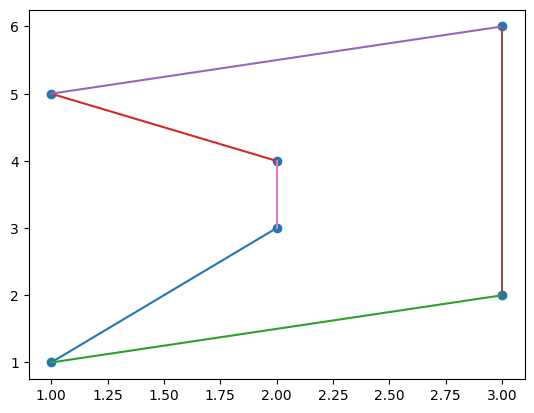

In [44]:
sample_coordinate_sequence = []
for i in range(len(sample_solutions)):
    res = containsNumber(sample_solutions[i])
    sample_coordinate_sequence.append(res)

plt.scatter(x_vals, y_vals)

for i in sample_coordinate_sequence:
    start = coordinates[i[0]]
    end = coordinates[i[1]]
    plt.plot([start[0], end[0]], [start[1], end[1]])

plt.show()

We can see we have the same optimal result, but this time with only 30 constraints, instead of 56. Though this may not seem like a drastic change, as we increase the number of nodes, we will see this difference. Before we present the calculator for comparing the two approaches, let us package this into a class. 

In [45]:
# Author: Amirali Malekani Nezhad, 2023

from __future__ import annotations
import itertools
from typing import Any

__all__ = ['QTSP', 'QTSP_Improved']

from abc import ABC, abstractmethod
from collections.abc import Container, Iterable
import os
os.chdir('..')

from dimod.serialization.format import Formatter
from dimod import ConstrainedQuadraticModel, Binary, quicksum, Real
from dwave.system import LeapHybridCQMSampler
import numpy as np
import itertools
from matplotlib import pyplot as plt


class QTSP_Improved(ABC):
    """ `QTSP_Improved` is a class for implementing a CQM for the Travelling Salesman Problem using
    Gavish-Graves subtour elimination constraint.

    Parameters
    ----------
    coordinates : Iterable[Iterable[float]]
        The coordinates of the nodes of the graph.
    time : int
        The time limit for the problem.
    log : bool
        Whether to log the output or not.
    """
    def __init__(self,
                 coordinates: Iterable[Iterable[float]],
                 time: int,
                 log: bool = True):
        self.coordinates = coordinates
        self.num_nodes = len(self.coordinates)
        self.time_limit = time
        self.log = log
        # Construct the CQM
        self.cqm = self.define_CQM()

    def define_distance_matrix(self):
        """ Function to define the distance matrix for the given coordinates. This
        provides support for asymmetrical TSP.
        """
        # Distance Matrix
        Distance_matrix = []
        temp_set = []

        # Function for calculating the euclidean distance
        def distance_between_points(point_A, point_B):
            return np.sqrt((point_A[0] - point_B[0]) ** 2 + (point_A[1] - point_B[1]) ** 2)

        # Generating the distance matrix
        for i in range(len(self.coordinates)):
            for j in range(len(self.coordinates)):
                temp_set.append(distance_between_points(self.coordinates[i], self.coordinates[j]))
            Distance_matrix.append(temp_set)
            temp_set = []

        return Distance_matrix

    def define_CQM(self):
        """ Function to define the CQM for the given graph.
        """
        # Define the number of nodes
        n = self.num_nodes

        # Construct the distance matrix
        Distance_matrix = self.define_distance_matrix()
    
        # Initialize the CQM
        cqm = ConstrainedQuadraticModel()

        # Initialize the objective
        objective = 0

        # Initialize the constraints
        constraint_1 = 0
        constraint_2 = 0
        constraint_3 = 0

        # Initialize the decision var
        X = np.array([[Binary(f"X_{i+1}_{j+1}") if i!=j else 0 for j in range(n)] for i in range(n)])
        Z = np.array([[Real(f"Z_{i+1}_{j+1}") if i!=j else 0 for j in range(n)] for i in range(n)])

        # Define objective
        objective = quicksum(Distance_matrix[i][j] * X[i][j] for i in range(n) for j in range(n))
        cqm.set_objective(objective)

        # Define Constraints (Only one entry and exit per node)
        for i in range(n):
            constraint_1 = quicksum(X[i][j] for j in range(n))
            cqm.add_constraint(constraint_1 == 1, label=f"Constraint 1-{i+1}")

        for j in range(n):
            constraint_2 = quicksum(X[i][j] for i in range(n))
            cqm.add_constraint(constraint_2 == 1, label=f"Constraint 2-{j+1}")

        # Define subtour elimination constraint
        for i in range(n):
            if i >= 1:
                constraint_3 = quicksum(Z[i][j] for j in range(n)) - quicksum(Z[j][i] for j in range(n) if j != 0)
                cqm.add_constraint(constraint_3 == 1, label=f"Constraint 3-{i+1}")

        for i in range(n):
            for j in range(n):
                if i != 0:
                    if X[i][j] == 0:
                        pass
                    else:
                        constraint_4 = Z[i][j] - (n-1) * X[i][j]
                        cqm.add_constraint(constraint_4, sense="<=", rhs=0, label=f"Constraint 4-{i+1}{j+1}")

        return cqm

    def __call__(self):
        # Running the sampler to get the sample set
        cqm_sampler = LeapHybridCQMSampler()
        sampleset = cqm_sampler.sample_cqm(self.cqm, label='CQM-TSP', time_limit=self.time_limit)

        if self.log:
            # Printing the sample set
            for c, cval in self.cqm.constraints.items():
                print(c, cval)

        feasible_sampleset = sampleset.filter(lambda d: d.is_feasible)

        sample = feasible_sampleset.first.sample

        if self.log:
            Formatter(width=1000).fprint(feasible_sampleset)

            for constraint in self.cqm.iter_constraint_data(sample):
                print(constraint.label, constraint.violation)

            for c, v in self.cqm.constraints.items():
                print('lhs : ' + str(v.lhs.energy(sample)))
                print('rhs : ' + str(v.rhs))
                print('sense  : ' + str(v.sense))
                print("---")

        sample_keys = sample.keys()
        sample_solutions = []
        for key in sample_keys:
            if sample.get(key) == 1:
                sample_solutions.append(key)
        
        if self.log:
            print(sample_solutions)

        def containsNumber(value):
            num_list = []
            for character in value:
                if character.isdigit():
                    num_list.append(int(character) - 1)
            return num_list
    
        sample_coordinate_sequence = []
        for i in range(len(sample_solutions)):
            res = containsNumber(sample_solutions[i])
            sample_coordinate_sequence.append(res)

        plt.scatter(self.coordinates[:, 0], self.coordinates[:, 1])

        for i in sample_coordinate_sequence:
            start = self.coordinates[i[0]]
            end = self.coordinates[i[1]]
            plt.plot([start[0], end[0]], [start[1], end[1]])

        plt.show()

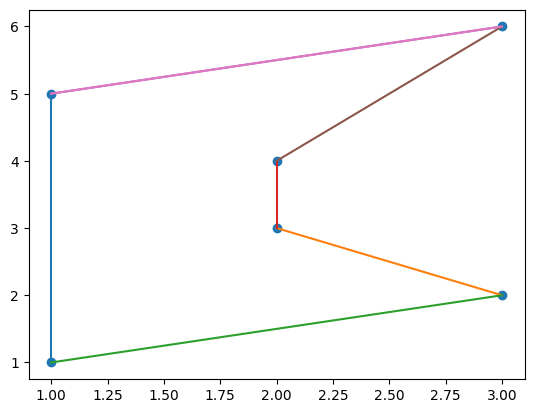

In [46]:
# List of coordinates
coordinates = np.array([[1, 1], [2, 3], [3, 2], [2, 4], [1, 5], [3, 6]])   # 6 nodes

tsp_model = QTSP_Improved(coordinates=coordinates, time=30, log=False)

tsp_model()

Something to note is that we no longer need the subtour generation method, which saves us a great amount of computation. Now we have an improved solver which scales polymonially to solve TSP using Quantum Annealers. Below, you can play with the number of nodes to see the overall number of constraints required for each approach!

In [ ]:
import ipywidgets as widgets
from IPython.display import display

def number_constraints(N: int) -> int:
    """
    Returns the number of constraints for a QUBO formulation of the
    Travelling Salesman Problem with N cities.
    """
    return 2**N + N - 2, (N - 1) * (N + 1) + 2 * N

# Define the interactive widget function
def interactive_number_constraints():
    N_widget = widgets.IntSlider(
        value=5,
        min=2,
        max=15,
        step=1,
        description='Number of Cities (N):',
        style={'description_width': 'initial'}
    )

    dfj_widget = widgets.Label()
    gg_widget = widgets.Label()

    def update_result(change):
        N = N_widget.value
        dfj_constraints, gg_constraints = number_constraints(N)
        dfj_widget.value = f"Number of Constraints to implement TSP with DFJ: {dfj_constraints}"
        gg_widget.value = f"Number of Constraints to implement TSP with GG: {gg_constraints}"

    N_widget.observe(update_result, 'value')

    update_result(None)  # Initial update of the result widget

    # Display the widgets
    display(N_widget, dfj_widget)
    display(gg_widget)

# Call the interactive widget function to show it in the Jupyter Notebook
interactive_number_constraints()

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

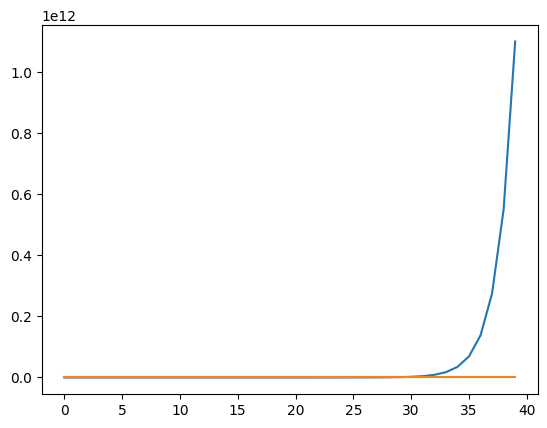

In [47]:
nodes = 40

plt.plot(range(nodes), [2**N + N - 2 for N in range(1, nodes+1)])
plt.plot(range(nodes), [(N - 1) * (N + 1) + 2*N for N in range(1, nodes+1)])

plt.plot

As we can see, the difference is quite drastic as we pass the threshold of 10 nodes (note the number of constraints is represented with 1e12). In the next and final notebook on QTSP, we will implement an application using this. The next notebook will not be focusing on QTSP's algorithm aspects, and instead will look into classical mapping of real-world maps to distance matrices, and providing different distance measures given the scale of the map.

## References

[1] : Bazrafshan, R.; Hashemkhani Zolfani, S.; Al-e-hashem, S.M.J.M. Comparison of the Sub-Tour Elimination Methods for the Asymmetric Traveling Salesman Problem Applying the SECA Method. Axioms 2021, 10, 19. https://doi.org/10.3390/axioms10010019

[2] : Gavish, B.; Graves, S. The Travelling Salesman Problem and Related Problems; Massachusetts Institute of Technology, Operations Research Center: Cambridge, MA, USA, 1978; p. 78.

<br>

<p>© 2023 Amirali Malekani Nezhad, all rights reserved.</p>

